<a href="https://colab.research.google.com/github/Dhaarani13/Project/blob/main/resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub
import os
import cv2
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm  # Progress bar for large datasets
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50  # Pre-trained ResNet50 model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint  # Training callbacks

In [2]:
# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/asl-alphabet


In [8]:

# Define paths
input_dir = "/kaggle/input/asl-alphabet/asl_alphabet_train/asl_alphabet_train/"
output_dir = "/root/.cache/kagglehub/datasets/processed_asl_alphabet/"

# Create output directory if it does not exist
os.makedirs(output_dir, exist_ok=True)

# Set target image size
IMG_SIZE = (100, 100)

# Function to preprocess images
def preprocess_images(input_dir, output_dir):
    for category in tqdm(os.listdir(input_dir)):  # Loop through A-Z, 0-9, etc.
        category_path = os.path.join(input_dir, category)
        output_category_path = os.path.join(output_dir, category)

        if not os.path.isdir(category_path):
            continue  # Skip if it's not a directory

        os.makedirs(output_category_path, exist_ok=True)  # Create category folder in output

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)  # Load image

            if img is None:
                continue  # Skip unreadable images

            img = cv2.resize(img, IMG_SIZE)  # Resize to 50x50
            img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale

            # Apply binary thresholding (adaptive for better hand detection)
            _, img_thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

            # Normalize pixel values (convert to float between 0 and 1)
            img_normalized = img_thresh / 255.0

            # Save preprocessed image
            save_path = os.path.join(output_category_path, img_name)
            cv2.imwrite(save_path, (img_normalized * 255).astype(np.uint8))  # Convert back to uint8

# Run preprocessing
preprocess_images(input_dir, output_dir)

print("Preprocessing completed. Saved in:", output_dir)



100%|██████████| 29/29 [08:12<00:00, 16.97s/it]

Preprocessing completed. Saved in: /root/.cache/kagglehub/datasets/processed_asl_alphabet/


In [11]:
# --- Configuration ---
IMAGE_SIZE = (224, 224)  # Input image dimensions (ResNet50 default)
BATCH_SIZE = 32  # Number of samples per batch
EPOCHS = 10  # Total training epochs
DATA_DIR = "/root/.cache/kagglehub/datasets/processed_asl_alphabet/"  # Dataset directory

# --- Data Augmentation & Preprocessing ---
# Create an ImageDataGenerator with light augmentation to prevent overfitting
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0,1]
    rotation_range=5,  # Random rotations (±5 degrees)
    width_shift_range=0.05,  # Random horizontal shifts (±5% of width)
    height_shift_range=0.05,  # Random vertical shifts (±5% of height)
    validation_split=0.2  # Reserve 20% of data for validation
)

# --- Data Generators ---
# Training data generator
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,  # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    subset='training',  # Use training subset (80%)
    shuffle=True  # Shuffle data for better generalization
)

# Validation data generator (no shuffling)
val_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'  # Use validation subset (20%)
)

# --- Model Architecture ---
# Load pre-trained ResNet50 (weights from ImageNet)
base_model = ResNet50(
    input_shape=(*IMAGE_SIZE, 3),  # 224x224 RGB images
    include_top=False,  # Exclude the default classification head
    weights='imagenet',  # Load pre-trained weights
    pooling='avg'  # Global average pooling for feature extraction
)
base_model.trainable = False  # Freeze all layers initially (transfer learning)

# Custom classification head
inputs = keras.Input(shape=(*IMAGE_SIZE, 3))  # Define input tensor
x = base_model(inputs, training=False)  # Pass input through frozen base model
x = layers.BatchNormalization()(x)  # Normalize activations
x = layers.Dropout(0.5)(x)  # Regularization to prevent overfitting
x = layers.Dense(256, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.3)(x)  # Additional regularization
outputs = layers.Dense(29, activation='softmax')(x)  # Output layer (29 ASL classes)

# Combine base model and custom head
model = keras.Model(inputs, outputs)

# --- Model Compilation ---
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Slow learning rate for fine-tuning
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.15),  # Helps generalization
    metrics=['accuracy']  # Track accuracy during training
)

# --- Callbacks ---
callbacks = [
    # Stop training if validation accuracy doesn't improve for 4 epochs
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    # Save the best model based on validation accuracy
    ModelCheckpoint('asl_steady_acc_model.keras', save_best_only=True)
]

# --- Training ---
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks  # Apply the defined callbacks
)

# --- Save Final Model ---
model.save('asl_resnet50.keras')  # Save the trained model

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 997s 452ms/step - accuracy: 0.1971 - loss: 3.0769 - val_accuracy: 0.3902 - val_loss: 2.4958 - learning_rate: 5.0000e-05
Epoch 2/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 969s 445ms/step - accuracy: 0.4408 - loss: 2.3546 - val_accuracy: 0.4556 - val_loss: 2.3195 - learning_rate: 5.0000e-05
Epoch 3/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 972s 447ms/step - accuracy: 0.5263 - loss: 2.1483 - val_accuracy: 0.4966 - val_loss: 2.2313 - learning_rate: 5.0000e-05
Epoch 4/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 976s 444ms/step - accuracy: 0.5711 - loss: 2.0425 - val_accuracy: 0.5128 - val_loss: 2.1735 - learning_rate: 5.0000e-05
Epoch 5/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 987s 446ms/step - accuracy: 0.6089 - loss: 1.9548 - val_accuracy: 0.5348 - val_loss: 2.1313 - learning_rate: 5.0000e-05
Epoch 6/10
2175/2175 ━━━━━━━━━━━━━━━━━━━━ 996s 458ms/step - accuracy: 0.6324 - loss: 1.9027 - val_accuracy: 0.5372 - val_loss: 2.1175 - learning_rate: 5.0000e-05
Epoch 7/10
2175/2175 ━━━━━━━

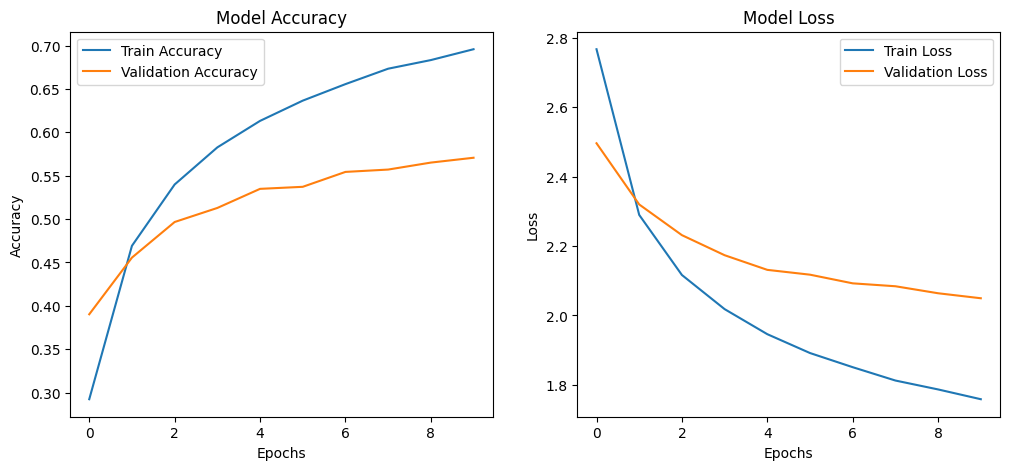

In [12]:

import matplotlib.pyplot as plt

# Train the model and store history
#history = model.fit(train_generator, validation_data=val_generator, epochs=EPOCHS)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.show()

544/544 ━━━━━━━━━━━━━━━━━━━━ 195s 358ms/step


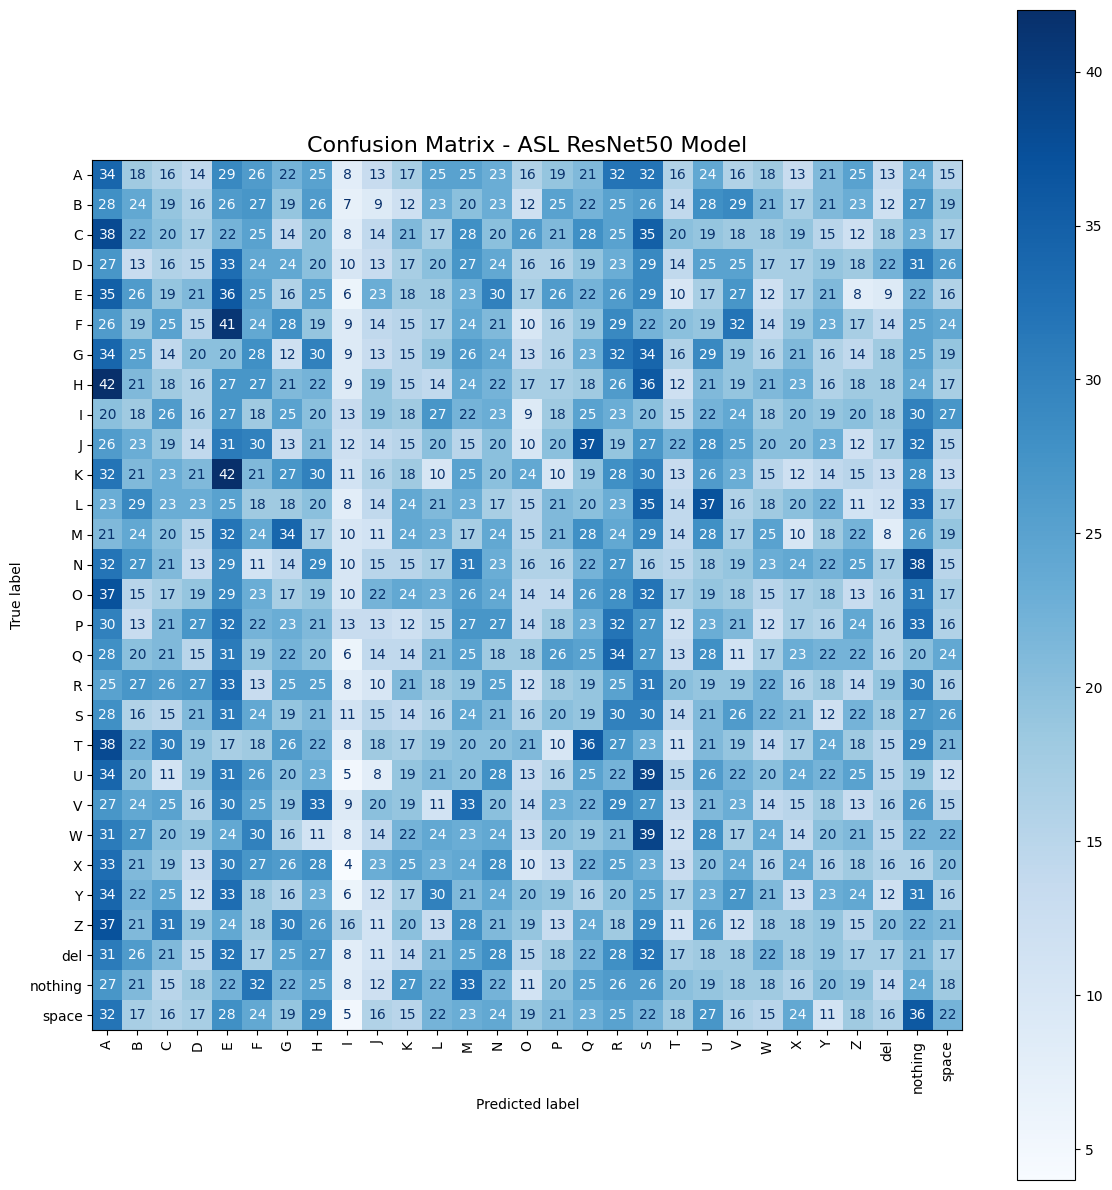

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Get true labels and predictions
val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Step 2: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 3: Create the plot with reduced size
fig, ax = plt.subplots(figsize=(12, 12))  # Reduced figure size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90, ax=ax)

plt.title("Confusion Matrix - ASL ResNet50 Model", fontsize=16)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import classification_report

# Step 1: Get true labels and predictions (already done)
val_generator.reset()
Y_pred = model.predict(val_generator, verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes

# Step 2: Get class labels
class_labels = list(val_generator.class_indices.keys())

# Step 3: Classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n")
print(report)


544/544 ━━━━━━━━━━━━━━━━━━━━ 200s 368ms/step
Classification Report:

              precision    recall  f1-score   support

           A       0.05      0.07      0.05       600
           B       0.04      0.04      0.04       600
           C       0.03      0.03      0.03       600
           D       0.03      0.03      0.03       600
           E       0.04      0.06      0.05       600
           F       0.04      0.04      0.04       600
           G       0.03      0.03      0.03       600
           H       0.05      0.06      0.05       600
           I       0.03      0.01      0.02       600
           J       0.03      0.02      0.03       600
           K       0.03      0.03      0.03       600
           L       0.03      0.03      0.03       600
           M       0.02      0.03      0.03       600
           N       0.03      0.04      0.04       600
           O       0.04      0.03      0.03       600
           P       0.04      0.03      0.03       600
           Q